In [75]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2
import os
import json

In [2]:
home_dir = '/home/alex/PycharmProjects/SynthText-python3/data/'
back_dir = '/home/alex/poker/'

## image

(<matplotlib.image.AxesImage at 0x7f2b37f13a90>,)

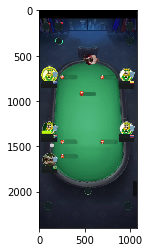

In [95]:
image = np.asarray(Image.open(back_dir + 'background_1.jpg'))
size = image.shape
plt.imshow(image), 

In [8]:
size

(2400, 1080, 3)

## Depth_map creation

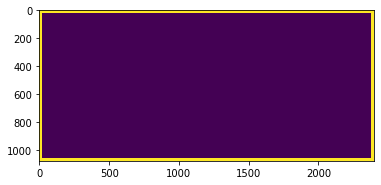

In [97]:
zero_area = (np.zeros((size[1],size[0]), dtype = "uint8"))
Image.fromarray(zero_area)
start_point = (20, 20) 
end_point = (size[0]-20, size[1]-20) 
color = (10, 10, 10)
thickness = -1
res = cv2.rectangle(zero_area, start_point, end_point, color, thickness) 
depth = (np.float32(res))
depth = np.where(depth == 0., 2.7, 1.34)
plt.imshow(depth)

## Segmentation creation

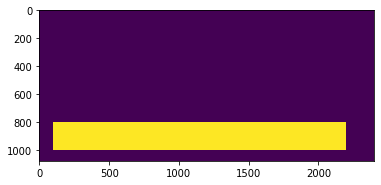

In [98]:
zero_area = (np.ones((size[1],size[0]), dtype = "uint8"))
Image.fromarray(zero_area)

start_point = (100, 1000) 
end_point = (2200, 800) 
color = (198, 198, 198)
thickness = -1
segmentation = cv2.rectangle(zero_area, start_point, end_point, color, thickness) 
plt.imshow(segmentation)

In [99]:
def count_area(array, label):
    count = 0
    for i in array:
        for j in i:
            if j == label:
                count += 1
    return count

In [100]:
seg_min = np.min(segmentation)
seg_max = np.amax(segmentation)
label = np.asarray([seg_min, seg_max])
label

array([  1, 198], dtype=uint8)

In [101]:
area_min = count_area(segmentation, seg_min)
area_max = count_area(segmentation, seg_max)
area = np.asarray([area_min,area_max])
area

array([2169699,  422301])

## Dset creation

In [102]:
with h5py.File(home_dir + 'dset.h5', 'w') as f:
    
    g2 = f.create_group('image')
    g2.create_dataset('test', data=image)
    
    g = f.create_group('depth')
    g.create_dataset('test', data=[depth,depth])
    
    g3 = f.create_group('seg')
    gg = g3.create_dataset('test', data=segmentation)
    
    gg.attrs['label'] = label    
    gg.attrs['area'] = area

## how its look like?

In [119]:
db_fname = '/home/alex/PycharmProjects/SynthText-python3/results/SynthText.h5'
result = h5py.File(db_fname, 'r')

In [120]:
(result['data']['test_0'][...]).shape

(2400, 1080, 3)

## BB coordinate

In [111]:
# bounding 2*4 box coordinate around each symbol
char = result['data']['test_0'].attrs['charBB']
char.shape

(2, 4, 17)

In [19]:
# why 17? because 
len('brute-forcesearch')

17

In [54]:
# word 2*4 coordinate
wordBB = result['data']['test_0'].attrs['wordBB']
wordBB.shape

(2, 4, 2)

In [57]:
coord = []
for i in range(wordBB.shape[-1]):
    bb = wordBB[:,:,i]        
    bb = np.c_[bb,bb[:,0]]
    #print ('___')
    box = []
    for j in range(4):        
        box += [[bb[0,j], bb[1,j]]]
    coord += [box]
print (coord)

___
___
[[[372.6208, 12.883743], [505.99017, 12.577629], [506.06165, 43.705765], [372.69226, 44.01188]], [[520.96027, 12.546314], [594.2111, 12.374538], [594.2841, 43.492954], [521.03326, 43.66473]]]


In [78]:
coord

[[[372.6208, 12.883743],
  [505.99017, 12.577629],
  [506.06165, 43.705765],
  [372.69226, 44.01188]],
 [[520.96027, 12.546314],
  [594.2111, 12.374538],
  [594.2841, 43.492954],
  [521.03326, 43.66473]]]

In [83]:
coord = np.asarray(coord).tolist()
with open("foo.txt", "w") as f:
    json.dump(coord, f)

## text semantic

In [112]:
text = result['data']['test_0'].attrs['txt']
text.shape

(1,)

In [113]:
text = (str(text).split(' '))
text

["[b'brute-force", "search']"]

## hdf5 unpack

In [61]:
result_path = '/home/alex/poker/data_gen_result/'

In [66]:
len([i for i in os.listdir(result_path) if i.endswith('.jpg')])

2

In [92]:
def unpack_hdf5_result(path_to_file, save_dir):
    # open
    result = h5py.File(path_to_file, 'r')
    
    # image save
    number_image = str(len([i for i in os.listdir(result_path) if i.endswith('.jpg')]))    
    img = Image.fromarray(result['data']['test_0'][...])
    img.save(save_dir + number_image + '.jpg')
    
    # word bounding boxes
    wordBB = result['data']['test_0'].attrs['wordBB']
    coord = []
    
    # word semantic
    text = result['data']['test_0'].attrs['txt']
    text = (str(text).split(' '))
    with open(save_dir+number_image+ '_text' + '.txt', "w") as f:
        json.dump(text, f)
    
    # json save
    for i in range(wordBB.shape[-1]):
        bb = wordBB[:,:,i]        
        bb = np.c_[bb,bb[:,0]]
   
        box = []
        for j in range(4):        
            box += [[bb[0,j], bb[1,j]]]
        coord += [box]
    coord = np.asarray(coord).tolist() 
    with open(save_dir+number_image+ '_word_BB' + '.txt', "w") as f:
        json.dump(coord, f)

In [128]:
sample = '/home/alex/PycharmProjects/SynthText-python3/results/SynthText.h5'
unpack_hdf5_result(sample,result_path)